In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds


Ініціалізуємо гіперпараметри

In [4]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

Завантажуэмо навчальний датасет та розбиваємо на навчальні і тестові дані

In [5]:
(train_data, val_data, test_data), metadata = tfds.load('cifar10', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],with_info=True)
print(metadata.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteXFUIP3/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteXFUIP3/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


Візуалізуємо наші навчальні дані

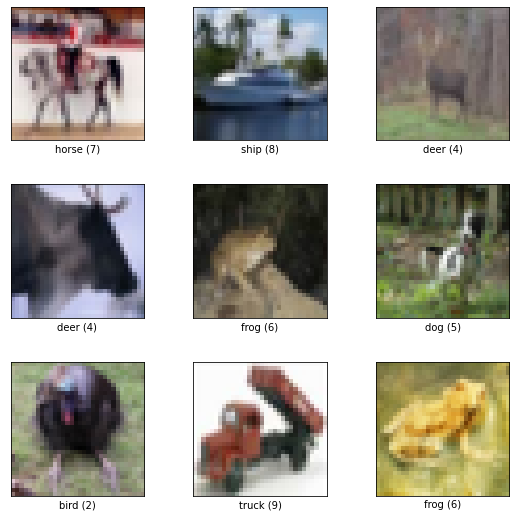

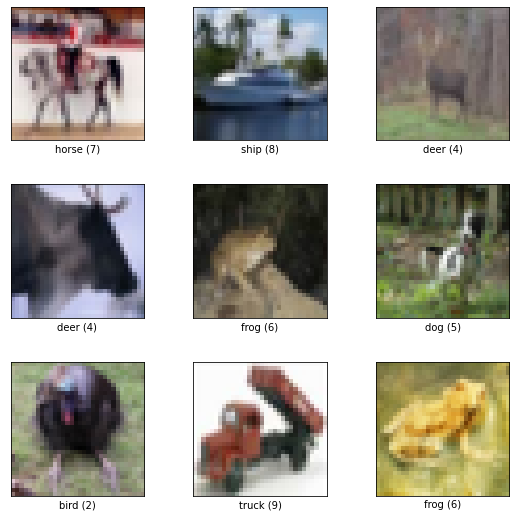

In [6]:
tfds.visualization.show_examples(train_data, metadata)

Обробляємо, приводимо до стандартного потрібного типу (нормалізуємо вхідні дані)

In [7]:
def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label


train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

**Створюємо Класифікація модель багатошаровий персептрон**

In [8]:
def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(32, 32, 3,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 404,010
Trainable params: 404,010
Non-trai

**Тренуємо модель**

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/20
69/69 [==============================] - 9s 106ms/step - loss: 2.1113 - accuracy: 0.2219 - val_loss: 1.9724 - val_accuracy: 0.2813
Epoch 2/20
69/69 [==============================] - 4s 55ms/step - loss: 1.9281 - accuracy: 0.3045 - val_loss: 1.8822 - val_accuracy: 0.3381
Epoch 3/20
69/69 [==============================] - 4s 55ms/step - loss: 1.8500 - accuracy: 0.3393 - val_loss: 1.8249 - val_accuracy: 0.3589
Epoch 4/20
69/69 [==============================] - 4s 62ms/step - loss: 1.8057 - accuracy: 0.3588 - val_loss: 1.7762 - val_accuracy: 0.3721
Epoch 5/20
69/69 [==============================] - 6s 86ms/step - loss: 1.7502 - accuracy: 0.3812 - val_loss: 1.7552 - val_accuracy: 0.3761
Epoch 6/20
69/69 [==============================] - 4s 53ms/step - loss: 1.7119 - accuracy: 0.3918 - val_loss: 1.7066 - val_accuracy: 0.3897
Epoch 7/20
69/69 [==============================] - 4s 55ms/step - loss: 1.6816 - accuracy: 0.4039 - val_loss: 1.7083 - val_accuracy: 0.3944
Epoch 8/20
6

Результат моделі на тестових даних

In [10]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

15/15 [==============================] - 1s 76ms/step - loss: 1.5556 - accuracy: 0.4483
Test loss : 1.5555793046951294
Test Accuracy : 0.4482666552066803


Графік train, test losses та accuracy

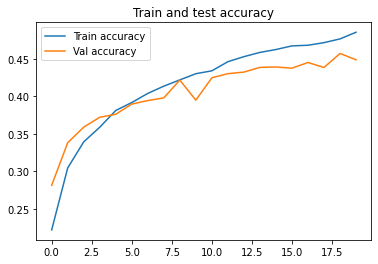

<Figure size 7200x7200 with 0 Axes>

In [11]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

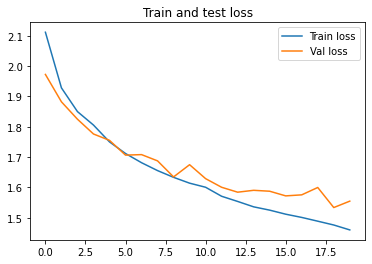

<Figure size 40000x40000 with 0 Axes>

In [12]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200), dpi=200)
plt.show()

In [13]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

(train_data, val_data, test_data), metadata = tfds.load('cifar10', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],with_info=True)
print(metadata.features)

def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label



train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [14]:
def simple_convolution_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(32, 32, 3,))
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='Classifier')

def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(32, 32, 3,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model = simple_convolution_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/10
1094/1094 [==============================] - 96s 87ms/step - loss: 1.6014 - accuracy: 0.4149 - val_loss: 1.3697 - val_accuracy: 0.5019
Epoch 2/10
1094/1094 [==============================] - 92s 84ms/step - loss: 1.2393 - accuracy: 0.5583 - val_loss: 1.1744 - val_accuracy: 0.5799
Epoch 3/10
1094/1094 [==============================] - 92s 84ms/step - loss: 1.0936 - accuracy: 0.6129 - val_loss: 1.0777 - val_accuracy: 0.6239
Epoch 4/10
1094/1094 [==============================] - 91s 83ms/step - loss: 1.0001 - accuracy: 0.6478 - val_loss: 1.0048 - val_accuracy: 0.6508
Epoch 5/10
1094/1094 [==============================] - 91s 83ms/step - loss: 0.9164 - accuracy: 0.6767 - val_loss: 0.9986 - val_accuracy: 0.6525
Epoch 6/10
1094/1094 [==============================] - 91s 83ms/step - loss: 0.8628 - accuracy: 0.6945 - val_loss: 0.9565 - val_accuracy: 0.6708
Epoch 7/10
1094/1094 [==============================] - 92s 84ms/step - loss: 0.8058 - accuracy: 0.7183 - val_loss: 0.9991 -

In [16]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

235/235 [==============================] - 6s 24ms/step - loss: 0.9532 - accuracy: 0.6816
Test loss : 0.9531897902488708
Test Accuracy : 0.6815999746322632


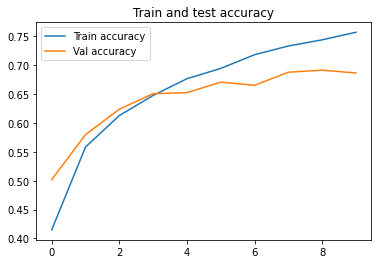

<Figure size 7200x7200 with 0 Axes>

In [17]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

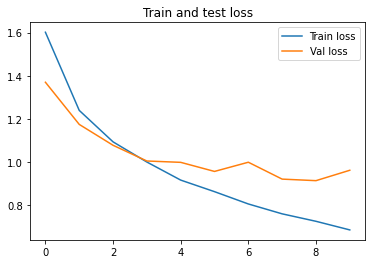

<Figure size 14400x14400 with 0 Axes>

In [18]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()

In [19]:
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 0.001

(train_data, val_data, test_data), metadata = tfds.load('cifar10', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],with_info=True)
print(metadata.features)

def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label



train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [22]:
def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(32, 32, 3,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               393344    
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [23]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/4
547/547 [==============================] - 10s 17ms/step - loss: 1.9492 - accuracy: 0.2964 - val_loss: 1.8143 - val_accuracy: 0.3605
Epoch 2/4
547/547 [==============================] - 6s 10ms/step - loss: 1.7914 - accuracy: 0.3619 - val_loss: 1.7506 - val_accuracy: 0.3889
Epoch 3/4
547/547 [==============================] - 6s 10ms/step - loss: 1.7401 - accuracy: 0.3795 - val_loss: 1.7499 - val_accuracy: 0.3867
Epoch 4/4
547/547 [==============================] - 6s 10ms/step - loss: 1.6977 - accuracy: 0.3972 - val_loss: 1.6862 - val_accuracy: 0.4057


In [24]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

118/118 [==============================] - 1s 12ms/step - loss: 1.6862 - accuracy: 0.4016
Test loss : 1.6862027645111084
Test Accuracy : 0.4016000032424927


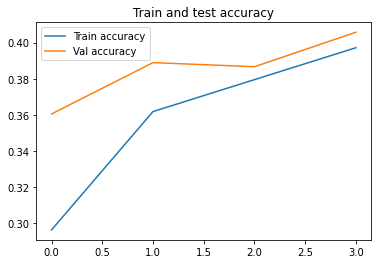

<Figure size 7200x7200 with 0 Axes>

In [25]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

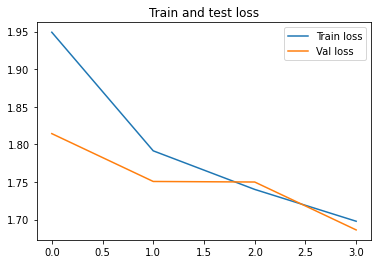

<Figure size 14400x14400 with 0 Axes>

In [26]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()